In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib
from skimage.transform import resize
from imageio import imread, imwrite
import pandas as pd
import glob
import pickle
import keras.backend as K

from stn.conv_model import conv_model
from stn.conv_model import conv_model_no_color_adjust
from sklearn.utils import resample
from lib.utils import load_gtsrb
from keras.metrics import sparse_categorical_accuracy

from parameters import *
from small_net import *

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras.backend.tensorflow_backend import set_session
set_session(sess)

In [9]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
n_train = len(X_train)
n_val = int(n_train*0.1)
ind = np.arange(n_train)
np.random.shuffle(ind)
# X_val, y_val = X_train[ind[:n_val]], y_train[ind[:n_val]]
# X_train, y_train = X_train[ind[n_val:]], y_train[ind[n_val:]]
X_val, y_val = X_test, y_test

data = (X_train[:, :, :, np.newaxis], y_train, 
        X_val[:, :, :, np.newaxis], y_val)

In [10]:
from cleverhans.utils import set_log_level
import logging

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [6]:
from hinge_net import HingeNet

hingenet = HingeNet("softmax_xent", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/softmax_xent.h5")
# hingenet.train_model(sess, data, n_epoch=15, batch_size=128)

In [11]:
hingenet.eval_model(sess, (X_test[:, :, :, np.newaxis], np.argmax(y_test, axis=1)))

(0.993, 0.02630199917015052)

In [17]:
fnc = K.function([hingenet.model.get_input_at(0)], [hingenet.model.layers[-2].output])

In [26]:
n = int(np.ceil(len(X_train) / 1000))
X_train_last = np.zeros([len(X_train), 128])
for i in range(n):
    start = i*1000
    end = (i + 1)*1000
    X_train_last[start:end] = fnc([X_train[start:end, :, :, np.newaxis], 0])[0]

In [27]:
n = int(np.ceil(len(X_test) / 1000))
X_test_last = np.zeros([len(X_test), 128])
for i in range(n):
    start = i*1000
    end = (i + 1)*1000
    X_test_last[start:end] = fnc([X_test[start:end, :, :, np.newaxis], 0])[0]

In [27]:
n = int(np.ceil(len(X_test) / 1000))
X_test_last = np.zeros([len(X_test), 128])
for i in range(n):
    start = i*100
    end = (i + 1)*100
    X_test_last[start:end] = fnc([X_test[start:end, :, :, np.newaxis]])[0]

In [66]:
from sklearn.svm import LinearSVC

svm = LinearSVC(penalty='l2', loss='squared_hinge', C=1e-10)
# svm = LinearSVC(penalty='l2', loss='hinge', C=1e-10)
svm.fit(X_train_last, np.argmax(y_train, axis=1))
print(svm.score(X_test_last, np.argmax(y_test, axis=1)))

w = np.swapaxes(svm.coef_, 0, 1)
hingenet.model.layers[-1].set_weights([w, svm.intercept_])
hingenet.eval_model(sess, (X_test[:, :, :, np.newaxis], np.argmax(y_test, axis=1)))

0.9812


(0.9812, 2.3017707790374757)

In [67]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

In [68]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.my_pgd import ProjectedGradientDescent

pgd_params = {'eps': 0.3,
              'eps_iter': 0.05,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 10,
              'rand_init': True,
              'batch_size': 100,
              'y_target': y_target}
pgd = ProjectedGradientDescent(hingenet, sess=sess)

y_tar = np.argmax(y_target, axis=1)
best_adv = np.zeros_like(X_atk)
best_dist = np.zeros([n_attack]) + 1e5
for i in range(10):
    adv = pgd.generate_np(X_atk, **pgd_params)
    print(hingenet.eval_model(sess, (adv, y_tar)))
    dist = np.sqrt(np.sum((adv - X_atk)**2, (1, 2, 3)))
    print(np.mean(dist))
    pred = hingenet.predict_model(sess, adv)
    y_pred = np.argmax(pred, axis=1)
    for j in range(n_attack):
        if y_pred[j] == y_tar[j] and dist[j] < best_dist[j]:
            best_adv[j] = adv[j]
            best_dist[j] = dist[j]
print(np.mean(best_dist < 1e5))
print(np.mean(best_dist[best_dist < 1e5]))

/home/research/nn_proof/lib/my_pgd.py:698: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-10-24 23:36:07,511 cleverhans] Constructing new graph for attack ProjectedGradientDescent


(0.727, 2.3022409267425537)
5.011963
(0.714, 2.3022437171936034)
5.01009
(0.709, 2.3022453060150148)
5.009878
(0.723, 2.3022397212982177)
5.019263
(0.724, 2.3022397651672364)
5.0121536
(0.715, 2.3022405643463135)
5.010965
(0.728, 2.302243320465088)
5.011129
(0.71, 2.30224001121521)
5.0152864
(0.714, 2.3022363338470457)
5.0121894
(0.738, 2.3022414054870604)
5.013011
0.812
4.907336935621177


In [73]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 1000
cw_params = {'binary_search_steps': 10,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 1e3,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-25 00:36:45,816 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-25 00:36:46,122 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-25 00:36:46,234 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-10-25 00:36:46,410 cleverhans]     Iteration 0 of 1000: loss=1.16 l2=0
[DEBUG 2018-10-25 00:36:50,030 cleverhans]     Iteration 100 of 1000: loss=1.13 l2=0.0373
[DEBUG 2018-10-25 00:36:53,654 cleverhans]     Iteration 200 of 1000: loss=1.13 l2=0.0373
[DEBUG 2018-10-25 00:36:53,655 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-10-25 00:36:53,666 cleverhans]   Successfully generated adversarial examples on 0 of 1000 instances.
/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[DEBUG 2018-10-25 00:40:17,356 cleverhans]     Iteration 300 of 1000: loss=8.01 l2=5.79
[DEBUG 2018-10-25 00:40:20,749 cleverhans]     Iteration 400 of 1000: loss=7.3 l2=5.6
[DEBUG 2018-10-25 00:40:24,101 cleverhans]     Iteration 500 of 1000: loss=6.83 l2=5.5
[DEBUG 2018-10-25 00:40:27,511 cleverhans]     Iteration 600 of 1000: loss=6.5 l2=5.48
[DEBUG 2018-10-25 00:40:30,892 cleverhans]     Iteration 700 of 1000: loss=6.27 l2=5.44
[DEBUG 2018-10-25 00:40:34,303 cleverhans]     Iteration 800 of 1000: loss=6.1 l2=5.44
[DEBUG 2018-10-25 00:40:37,698 cleverhans]     Iteration 900 of 1000: loss=5.96 l2=5.43
[DEBUG 2018-10-25 00:40:41,070 cleverhans]   Successfully generated adversarial examples on 1000 of 1000 instances.
[DEBUG 2018-10-25 00:40:41,071 cleverhans]    Mean successful distortion: 2.307
[DEBUG 2018-10-25 00:40:41,073 cleverhans]   Binary search step 8 of 10
[DEBUG 2018-10-25 00:40:41,091 cleverhans]     Iteration 0 of 1000: loss=26.8 l2=0
[DEBUG 2018-10-25 00:40:44,538 cleverh

1.0489577


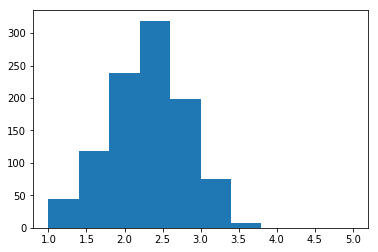

In [76]:
dist = np.sqrt(np.sum((X_atk - adv)**2, (1, 2, 3)))
plt.hist(dist, bins=10, range=(1, 5))
print(np.min(dist))

In [113]:
from sklearn.svm import LinearSVC

svm = LinearSVC(penalty='l2', loss='hinge', C=1e-10)
# svm = LinearSVC(penalty='l2', loss='hinge', C=1e-10)
svm.fit(X_train_last, np.argmax(y_train, axis=1))
print(svm.score(X_test_last, np.argmax(y_test, axis=1)))

w = np.swapaxes(svm.coef_, 0, 1)
hingenet.model.layers[-1].set_weights([w, svm.intercept_])
hingenet.eval_model(sess, (X_test[:, :, :, np.newaxis], np.argmax(y_test, axis=1)))

0.9812


(0.9812, 2.3021776069641113)

In [114]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

In [115]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.my_pgd import ProjectedGradientDescent

pgd_params = {'eps': 0.3,
              'eps_iter': 0.05,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 10,
              'rand_init': True,
              'batch_size': 100,
              'y_target': y_target}
pgd = ProjectedGradientDescent(hingenet, sess=sess)

y_tar = np.argmax(y_target, axis=1)
best_adv = np.zeros_like(X_atk)
best_dist = np.zeros([n_attack]) + 1e5
for i in range(10):
    adv = pgd.generate_np(X_atk, **pgd_params)
    print(hingenet.eval_model(sess, (adv, y_tar)))
    dist = np.sqrt(np.sum((adv - X_atk)**2, (1, 2, 3)))
    print(np.mean(dist))
    pred = hingenet.predict_model(sess, adv)
    y_pred = np.argmax(pred, axis=1)
    for j in range(n_attack):
        if y_pred[j] == y_tar[j] and dist[j] < best_dist[j]:
            best_adv[j] = adv[j]
            best_dist[j] = dist[j]
print(np.mean(best_dist < 1e5))
print(np.mean(best_dist[best_dist < 1e5]))

/home/research/nn_proof/lib/my_pgd.py:698: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-10-25 01:02:42,567 cleverhans] Constructing new graph for attack ProjectedGradientDescent


(0.723, 2.3024125308990477)
5.0168543
(0.72, 2.3024120483398436)
5.0154023
(0.725, 2.302412687301636)
5.0101542
(0.722, 2.302414213180542)
5.010916
(0.715, 2.302413173675537)
5.0168047
(0.716, 2.3024136848449706)
5.0125146
(0.716, 2.3024140129089354)
5.014616
(0.715, 2.302415460586548)
5.013233
(0.715, 2.302413631439209)
5.012317
(0.716, 2.3024129333496095)
5.014382
0.822
4.913935917717407


In [116]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 500
cw_params = {'binary_search_steps': 10,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 1e3,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-25 01:02:59,116 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-25 01:02:59,495 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-25 01:02:59,624 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-10-25 01:02:59,870 cleverhans]     Iteration 0 of 500: loss=0.583 l2=0
[DEBUG 2018-10-25 01:03:01,769 cleverhans]     Iteration 50 of 500: loss=0.573 l2=0.00968
[DEBUG 2018-10-25 01:03:03,650 cleverhans]     Iteration 100 of 500: loss=0.573 l2=0.00944
[DEBUG 2018-10-25 01:03:05,502 cleverhans]     Iteration 150 of 500: loss=0.573 l2=0.00944
[DEBUG 2018-10-25 01:03:05,503 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-10-25 01:03:05,513 cleverhans]   Successfully generated adversarial examples on 0 of 1000 instances.
/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: Runti

[DEBUG 2018-10-25 01:05:03,735 cleverhans]     Iteration 400 of 500: loss=7.42 l2=6.51
[DEBUG 2018-10-25 01:05:05,913 cleverhans]     Iteration 450 of 500: loss=7.09 l2=6.39
[DEBUG 2018-10-25 01:05:08,105 cleverhans]   Successfully generated adversarial examples on 1000 of 1000 instances.
[DEBUG 2018-10-25 01:05:08,105 cleverhans]    Mean successful distortion: 2.495
[DEBUG 2018-10-25 01:05:08,106 cleverhans]   Binary search step 8 of 10
[DEBUG 2018-10-25 01:05:08,139 cleverhans]     Iteration 0 of 500: loss=34.5 l2=0
[DEBUG 2018-10-25 01:05:10,234 cleverhans]     Iteration 50 of 500: loss=11.7 l2=7.71
[DEBUG 2018-10-25 01:05:12,336 cleverhans]     Iteration 100 of 500: loss=10.8 l2=7.33
[DEBUG 2018-10-25 01:05:14,487 cleverhans]     Iteration 150 of 500: loss=10.2 l2=7.31
[DEBUG 2018-10-25 01:05:16,713 cleverhans]     Iteration 200 of 500: loss=9.58 l2=7.16
[DEBUG 2018-10-25 01:05:18,914 cleverhans]     Iteration 250 of 500: loss=8.88 l2=6.92
[DEBUG 2018-10-25 01:05:21,116 cleverhans]

In [48]:
from sklearn.svm import SVC
svm = SVC(C=1e-7, kernel='linear')
svm.fit(X_train_last, np.argmax(y_train, axis=1))

SVC(C=1e-07, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [49]:
svm.score(X_test_last, np.argmax(y_test, axis=1))

0.1135

In [46]:
from sklearn.svm import SVC
svm = SVC(C=1e2, kernel='linear')
svm.fit(X_train_last, np.argmax(y_train, axis=1))

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [47]:
svm.score(X_test_last, np.argmax(y_test, axis=1))

0.1981

In [50]:
from sklearn.svm import SVC
svm = SVC(C=1e7, kernel='linear')
svm.fit(X_train_last, np.argmax(y_train, axis=1))

SVC(C=10000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [51]:
svm.score(X_test_last, np.argmax(y_test, axis=1))

0.1981